## Imports

In [2]:
from importlib import reload
import sys
import os

current_dir = os.getcwd() 
sys.path.append(os.path.join(current_dir, '..'))

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Traffic Signal Controller Reinforcement Learning Modules
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl
from tscRL.agents import ql_agent, fixedTL_agent as ftl_agent

# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
    



In [3]:
reload(ql_agent)
reload(ftl_agent)
reload(sys.modules['tscRL.environments.environment'])



<module 'tscRL.environments.environment' from '/home/juanma/Dev/ia-uncuyo-2022/proyecto_final/code/experiments/../tscRL/environments/environment.py'>

## Parameter Exploration

### Epsilon Greedy Policy

#### Estrategias para decaer Epsilon en Epsilon-Greedy 

In [4]:
# Exponencial
def calculate_exp_epsilon(decayRate, steps, startEpsilon=1.0, endEpsilon=0.001):
    x = np.arange(steps)
    y = endEpsilon + (startEpsilon - endEpsilon) * np.exp(-decayRate * x)
    return x, y

# Lineal
def calculate_linear_epsilon(steps, startEpsilon=1.0, endEpsilon=0.001):
    slope = (startEpsilon - endEpsilon) / steps
    x = np.arange(steps)
    y = startEpsilon - slope * x
    y = np.maximum(y, endEpsilon)  # Asegura que el valor mínimo sea endEpsilon
    return x, y

#### Decay rates
Rasa con la que decae epsilon a través de los pasos de tiempo (steps)

In [5]:
decay_rates = [0.01, 0.02, 0.025, 0.03, 0.05]

#### Análisis de funciones epsilon a través del tiempo

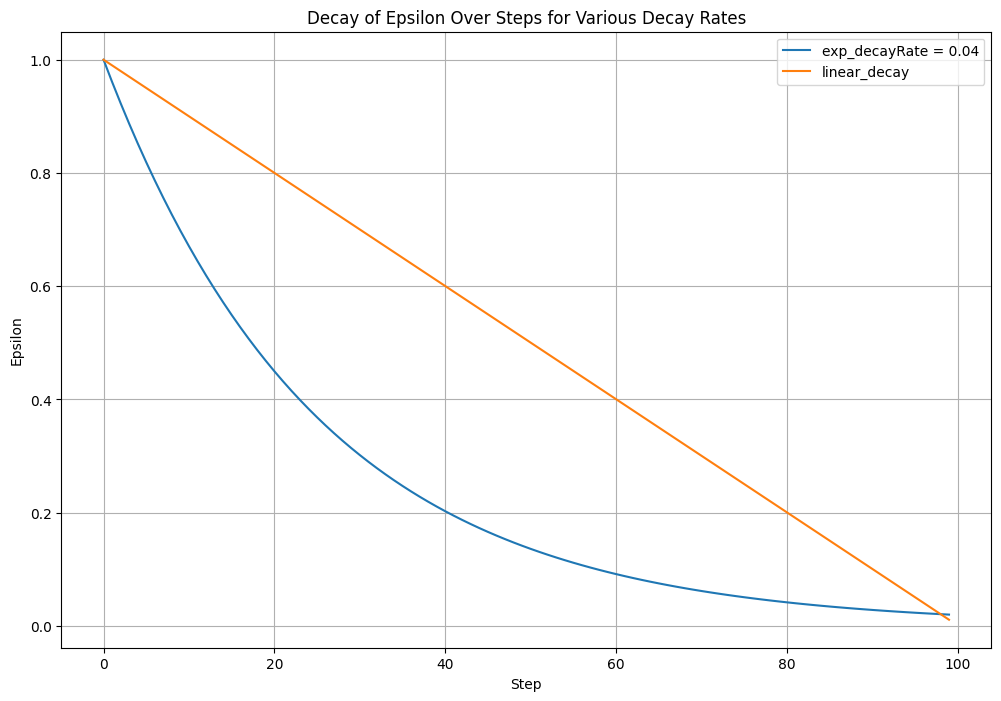

In [6]:
episodes = 100

endEpsilon = 0.01
startEpsilon = 1

plt.figure(figsize=(12, 8))

for decayRate in [0.04]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')

x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')

plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
decay_rates = [0.02, 0.03]

In [8]:
start_epsilons = [1, 0.8]

### Q-Learning - Parámetros

#### Delta time
Tiempo de simulación (en segundos) entre pasos (steps)

In [9]:
delta_times = [5]

#### Phases
Posibles fases de un semáforo. Determina el espacio de acción (action space)

In [10]:
phases_list = [{'init':   tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'ns_sn_l':   tl.Phase("GGGgrrrrGGGgrrrr", "yyyyrrrryyyyrrrr"), #
        'ew_we_l':   tl.Phase("rrrrGGGgrrrrGGGg", "rrrryyyyrrrryyyy"), #
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),  # 4 phases
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),  #
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),  #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")   #
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),  # 4 phases
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),  #
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),  #
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),  #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")   # 
        }]
             

#### Edges
Parámetro que determina si se usaran aristas (edges), en vez de carriles (lanes). En la siguiente figura se puede observar la diferencia


<div style="text-align:center;"><img src="./images/lane_vs_edge.png" alt="lane vs edge" width="800"></div>





In [11]:
edges = [False, True]

#### Intervalos de codificación
Cantidad de intervalos que se usarán para codificar (discretizar) los estados.


In [12]:
encode_intervals = [8, 10, 14]

#### Función de recompensa
Para computar la recompensa se cuenta con dos funciones:
- Diferencia de sumatoria de todos los tiempos de espera (*diff_waitingTime*)
- Diferencia de vehículos detenidos (*diff_halted*)

In [13]:
# rewardFn = ["diff_halted", "diff_waitingTime", "diff_cumulativeWaitingTime"]
reward_fns = list(SumoEnvironment.rewardFns.keys())

In [14]:
reward_fns

['diff_halted', 'diff_waitingTime', 'diff_cumulativeWaitingTime']

#### Lane Info
Que información es más relevante para capturar el estado de tráfico en un carril (o arista)?

In [15]:
lane_info = ["halted", "waitingTime"]

In [16]:
learning_rates = [0.1, 0.01, 0.001]

In [17]:
param_grid = {
    "lane_info": lane_info,
    "reward_fns": reward_fns,
    "encode_intervals": encode_intervals,
    "phases": phases_list,
    "decay_rates": decay_rates,
    "learning_rates": learning_rates,
    "start_epsilons": start_epsilons
}

In [18]:
def serializeParamResults(results, fileName):
    rows = []
    for result in results:
        params = result['params']
        for metric in result['metrics']:
            if 'elapsed_time' in metric:
                row = {
                    'params': params,
                    'episode': metric['episode'],
                    'cumulative_reward': metric['cumulative_reward'],
                    'mean_waiting_time': metric['mean_waiting_time'],
                    'elapsed_time': metric['elapsed_time']
                }
                rows.append(row)
            else:
                row = {
                    'params': params,
                    'episode': metric['episode'],
                    'cumulative_reward': metric['cumulative_reward'],
                    'mean_waiting_time': metric['mean_waiting_time']
                }
                rows.append(row)
                
    # Crear un DataFrame a partir de los datos
    df = pd.DataFrame(rows)
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(fileName, index=False)
    
def deserializeParamResults(fileName):
    # Leer el archivo CSV en un DataFrame
    df = pd.read_csv(fileName)
    
    results = []
    # Crear un diccionario temporal para agrupar los resultados por parámetros
    temp_results = {}
    
    for index, row in df.iterrows():
        params = row['params']
        metric = {
            'episode': row['episode'],
            'cumulative_reward': row['cumulative_reward'],
            'mean_waiting_time': row['mean_waiting_time']
        }
        
        if 'elapsed_time' in row:
            metric['elapsed_time'] = row['elapsed_time']
        
        if params not in temp_results:
            temp_results[params] = {
                'params': params,
                'metrics': []
            }
        
        temp_results[params]['metrics'].append(metric)
    
    # Convertir el diccionario temporal a la lista de resultados
    for key, value in temp_results.items():
        results.append(value)
    
    return results

def serializeRunsResults(results, fileName):
    rows = []
    for result in results:
        run = result['run']
        for metric in result['metrics']:
            if 'elapsed_time' in metric:
                row = {
                    'run': run,
                    'episode': metric['episode'],
                    'cumulative_reward': metric['cumulative_reward'],
                    'mean_waiting_time': metric['mean_waiting_time'],
                    'elapsed_time': metric['elapsed_time']
                }
                rows.append(row)
            else:
                row = {
                    'run': run,
                    'episode': metric['episode'],
                    'cumulative_reward': metric['cumulative_reward'],
                    'mean_waiting_time': metric['mean_waiting_time']
                }
                rows.append(row)
                
    # Crear un DataFrame a partir de los datos
    df = pd.DataFrame(rows)
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(fileName, index=False)
    
def deserializeRunsResults(fileName):
    # Leer el archivo CSV en un DataFrame
    df = pd.read_csv(fileName)
    
    results = []
    # Crear un diccionario temporal para agrupar los resultados por parámetros
    temp_results = {}
    
    for index, row in df.iterrows():
        run = row['run']
        metric = {
            'episode': row['episode'],
            'cumulative_reward': row['cumulative_reward'],
            'mean_waiting_time': row['mean_waiting_time']
        }
        
        if 'elapsed_time' in row:
            metric['elapsed_time'] = row['elapsed_time']
        
        if run not in temp_results:
            temp_results[run] = {
                'run': run,
                'metrics': []
            }
        
        temp_results[run]['metrics'].append(metric)
    
    # Convertir el diccionario temporal a la lista de resultados
    for key, value in temp_results.items():
        results.append(value)
    
    return results

def serializeMetrics(metrics, fileName):
        
    df = pd.DataFrame(metrics)
    # Guardar el DataFrame en un archivo CSV
    df.to_csv(fileName, index=False)
    
def deserializeMetrics(fileName):
    # Leer el archivo CSV en un DataFrame
    df = pd.read_csv(fileName)
    return df

    
def split_long_string(s, max_length):
    words = s.split(',')
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += ("," if current_line else "") + word
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return "\n".join(lines)

In [19]:
sumoCfgFile_param_exploration = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced_params.sumocfg'))

In [20]:
results_params_0 = []

for lane_info in param_grid["lane_info"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn="diff_waitingTime", fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.04, episodes=100)
    params = "lane_info:" + str(lane_info)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_0.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: lane_info:halted
 Retrying in 1 seconds
Learning with: lane_info:waitingTime


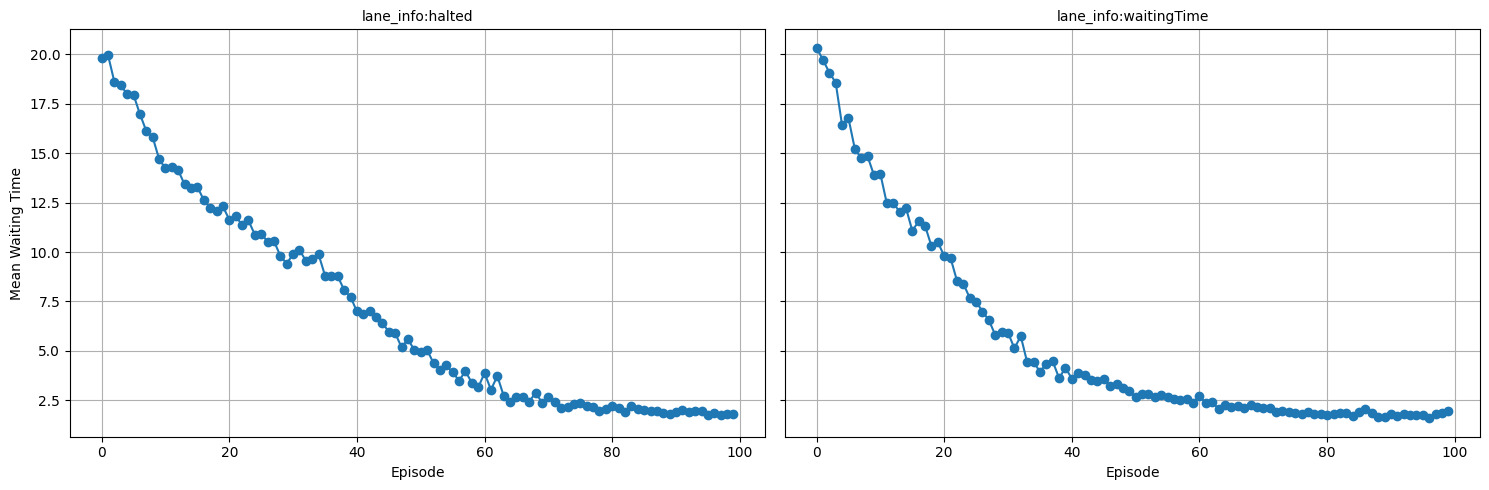

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_0):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i==0:
        axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

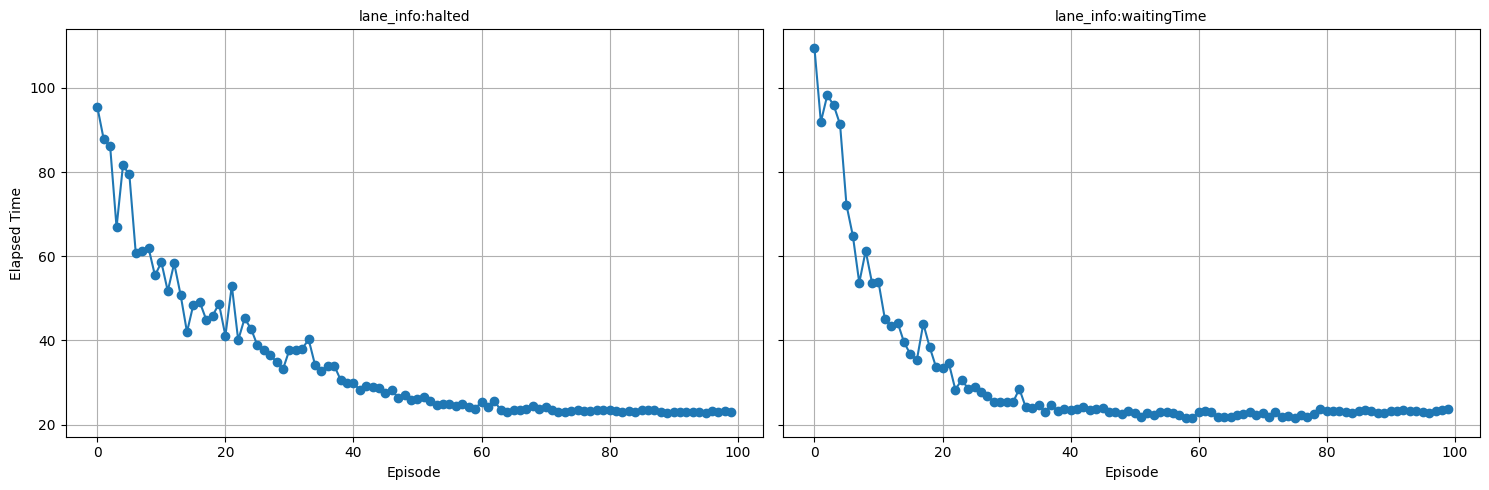

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_0):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['elapsed_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i==0:
        axes[i].set_ylabel('Elapsed Time')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [37]:
serializeParamResults(results_params_0, "results_params_0_100ep.csv")

In [ ]:
results_params_1 = []

for lane_info in param_grid["lane_info"]:
    for reward_fn in param_grid["reward_fns"]:
        env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
        agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
        params = "lane_info:" + str(lane_info) + ",reward_fn:" + str(reward_fn)
        print("Learning with: " + params)
        metrics = agent.train();
        results_params_1.append({"params": params, "metrics": metrics })

In [70]:
serializeParamResults(results_params_1, "results_params_1.csv")

In [32]:
if 'results_params_1' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_params_1 = deserializeParamResults("results_params_1.csv")

La variable ya existe en el ámbito local.


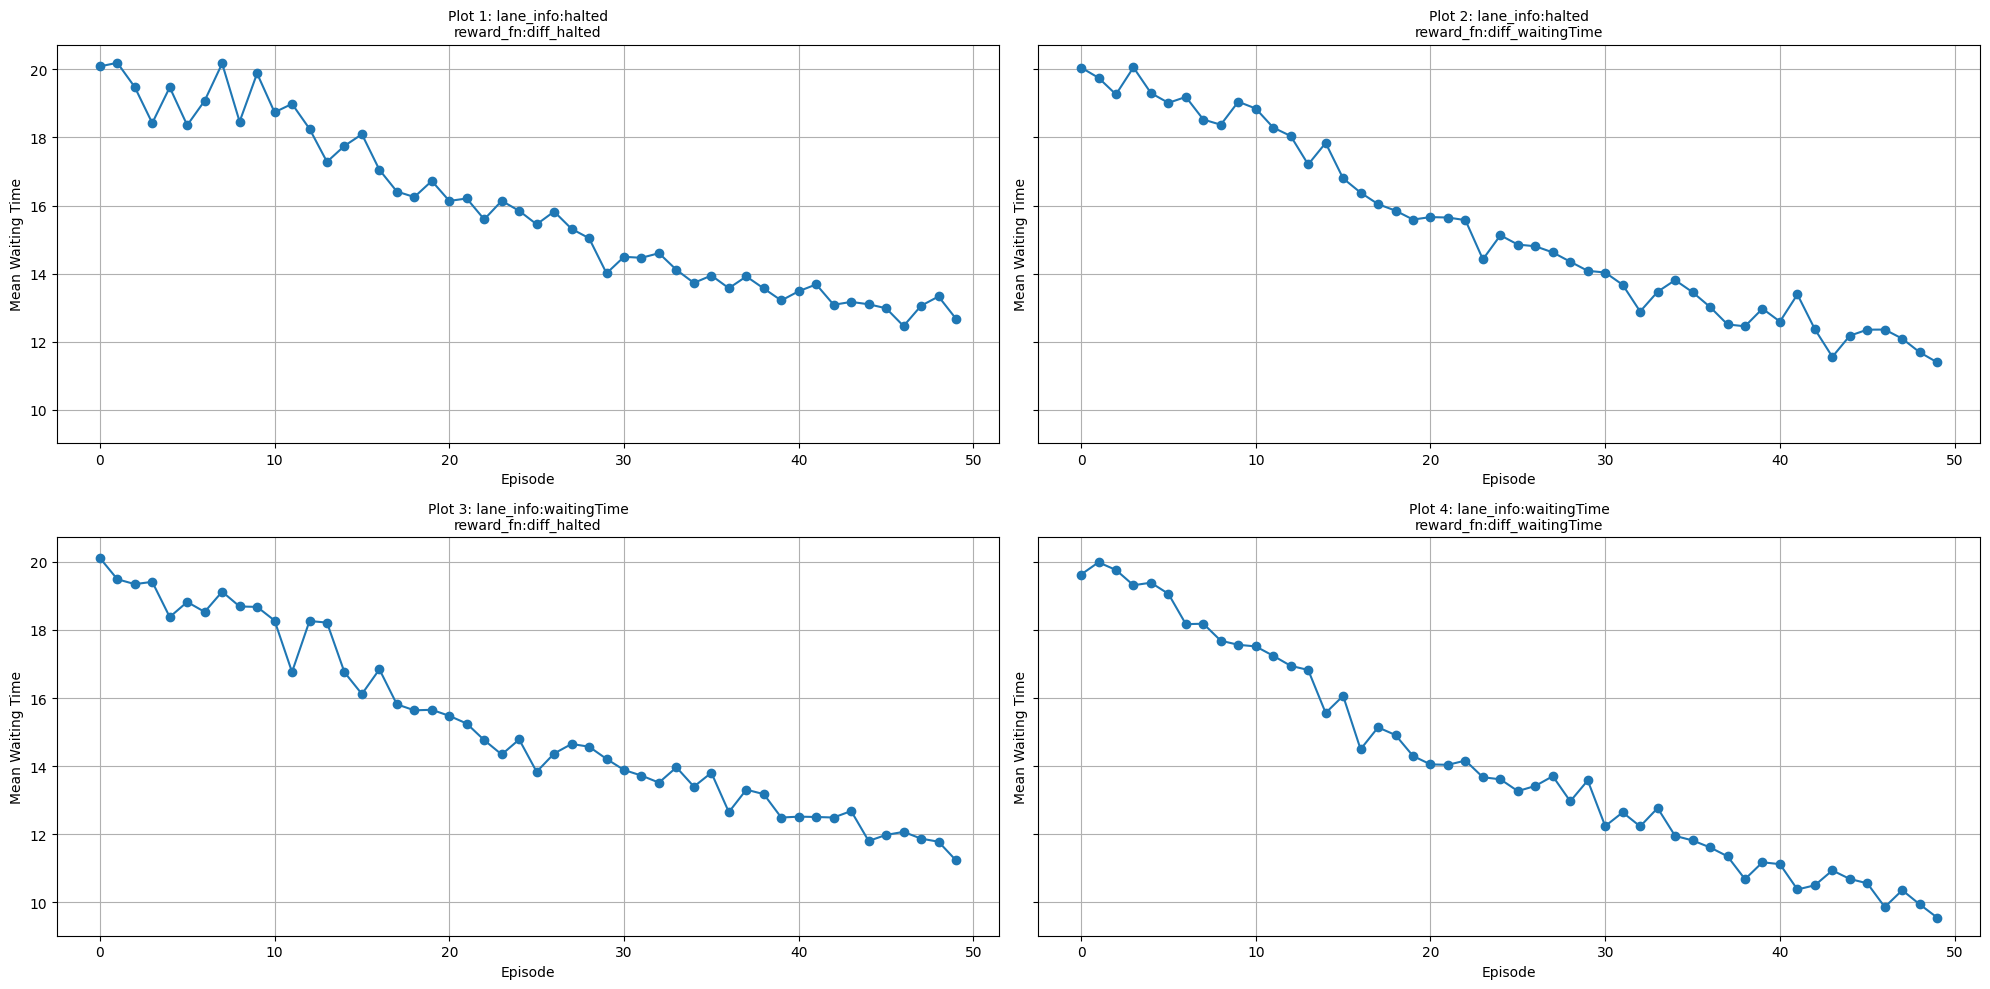

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_1):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()
    

In [20]:
lane_info = "waitingTime"

In [26]:
results_rewardFn = []
for reward_fn in param_grid["reward_fns"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.05, episodes=50)
    params = "reward_fn:" + str(reward_fn)
    print("Learning with: " + params)
    metrics = agent.train();
    results_rewardFn.append({"params": params, "metrics": metrics })

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: reward_fn:diff_halted
 Retrying in 1 seconds
Learning with: reward_fn:diff_waitingTime
 Retrying in 1 seconds
Learning with: reward_fn:diff_cumulativeWaitingTime


In [40]:
serializeParamResults(results_rewardFn, "results_rewardFn.csv")

In [42]:
if 'results_rewardFn' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_rewardFn = deserializeParamResults("results_rewardFn.csv")

In [29]:
'''
results_rewardFn = []

for reward_fn in [ "diff_cumulativeWaitingTime", "diff_waitingTime"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.05, episodes=50)
    params = "reward_fn:" + str(reward_fn)
    print("Learning with: " + params)
    metrics = agent.train();
    
    results_rewardFn.append({"params": params, "metrics": metrics })
    
'''

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: reward_fn:diff_cumulativeWaitingTime
 Retrying in 1 seconds
Learning with: reward_fn:diff_waitingTime


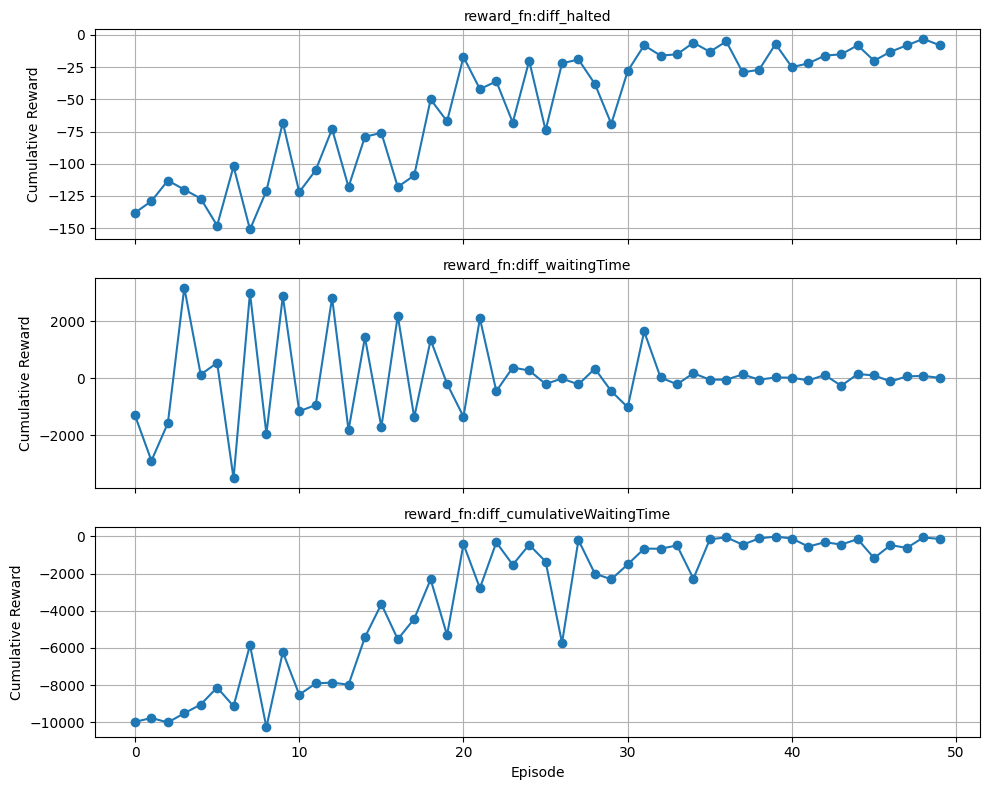

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)
axes = axes.flatten()

for i, result in enumerate(results_rewardFn):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['cumulative_reward'], marker='o')
    
    if i == len(results_rewardFn)-1:
        axes[i].set_xlabel('Episode')
    
    axes[i].set_ylabel('Cumulative Reward')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [50]:
env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn="diff_halted", fixedTL=False, simTime=43800, sumoLog=False)
agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.05, episodes=100)
params = "reward_fn:" + "diff_halted"
print("Learning with: " + params)
metrics_diff_halted_100 = agent.train();


Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: reward_fn:diff_halted


/tmp/ipykernel_587494/637509670.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


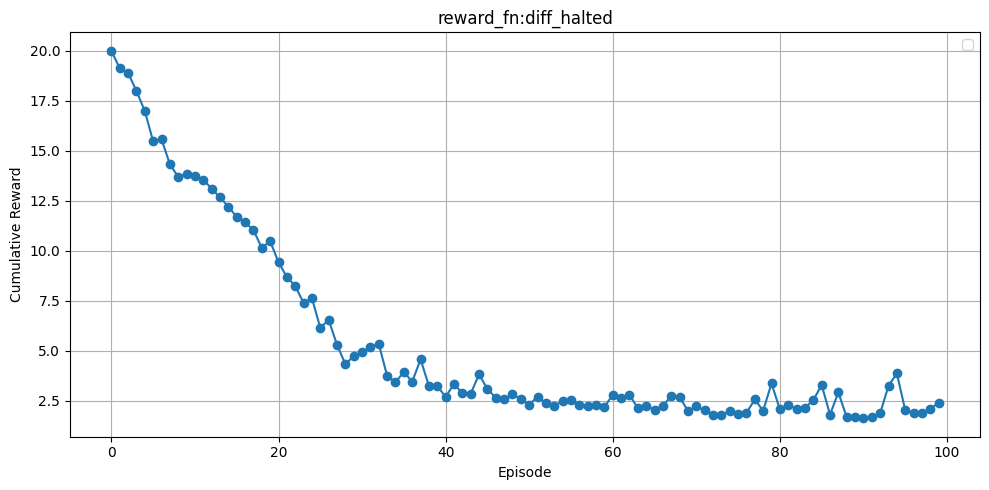

In [53]:
plt.figure(figsize=(10, 5))

df = pd.DataFrame(metrics_diff_halted_100)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')

# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.title(split_long_string(f"{params}", 40))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

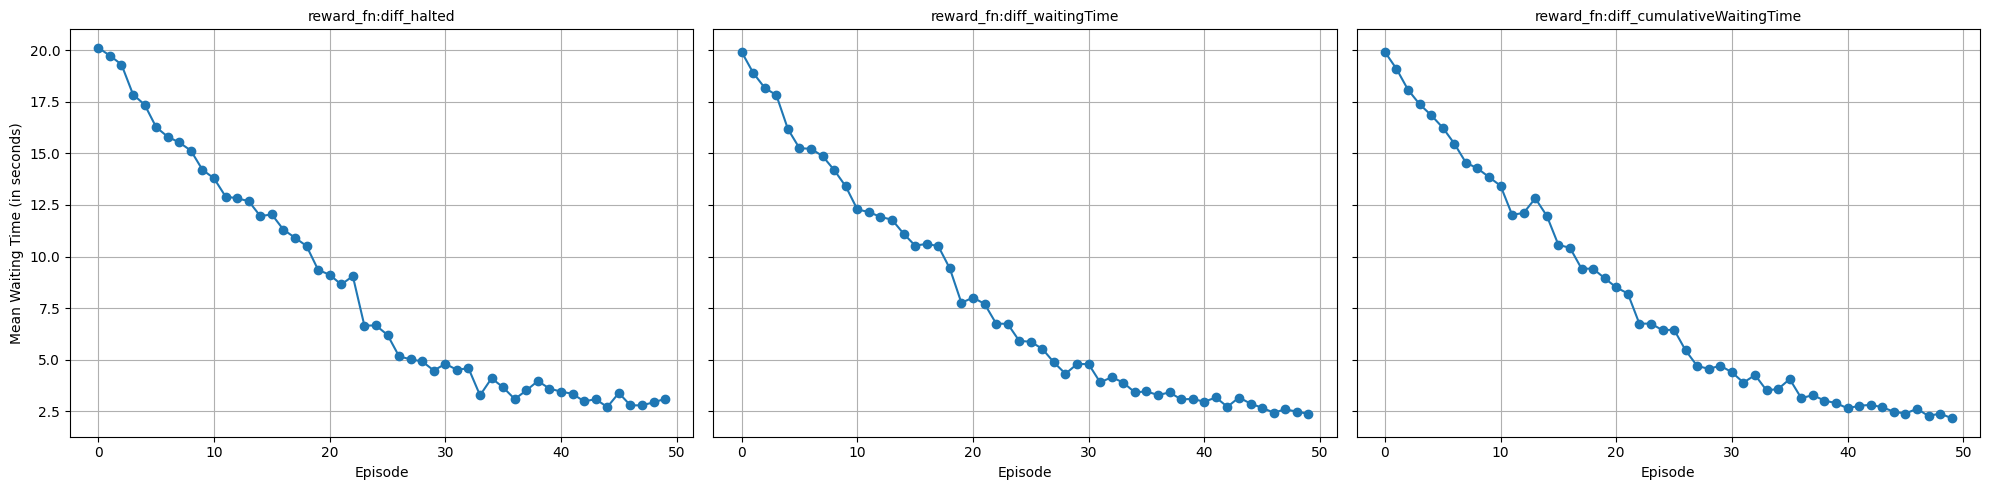

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_rewardFn):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

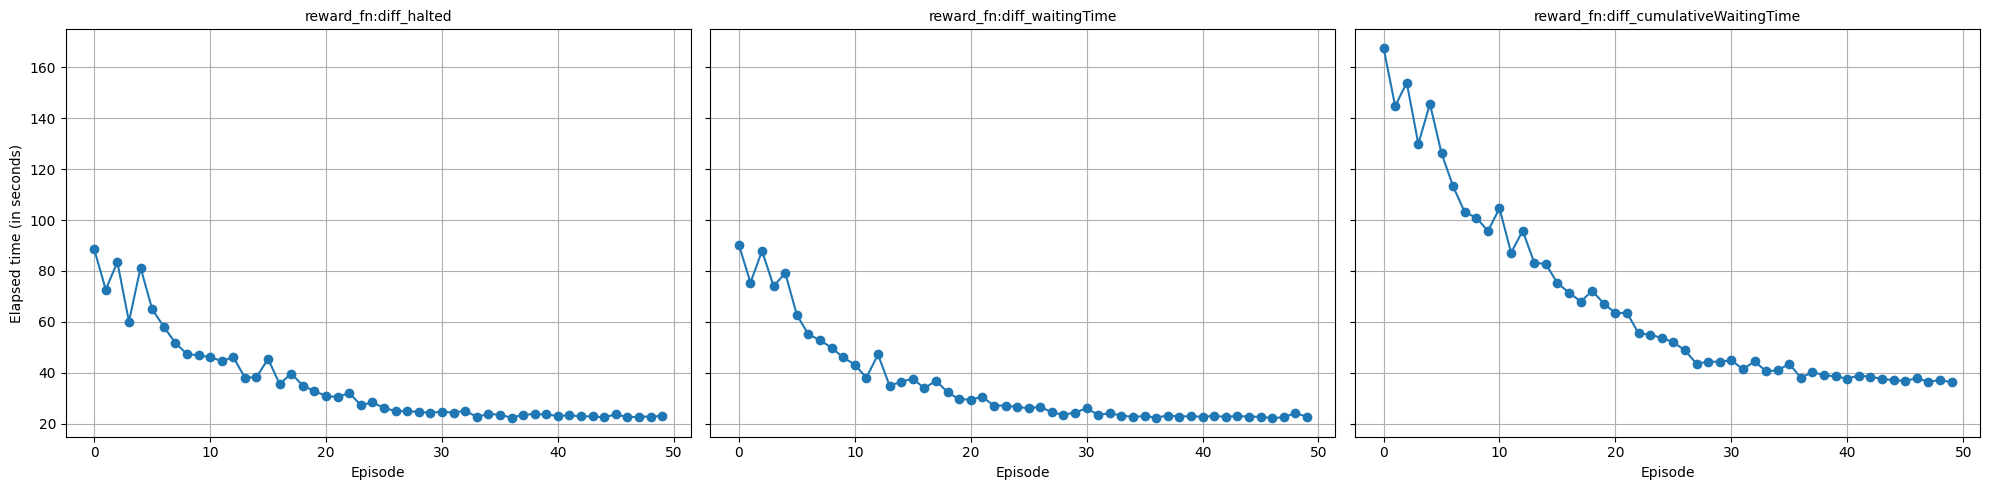

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_rewardFn):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['elapsed_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Elapsed time (in seconds)')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [55]:
for result in results_rewardFn:
    params = result["params"]
    metrics = result["metrics"]
    totalElapsedTime = 0
    for metric in metrics:
        totalElapsedTime += metric["elapsed_time"]
    print(params)
    print( "          \\_ Training Time: " + str(totalElapsedTime))
        

reward_fn:diff_halted
          \_ Training Time: 1801.1358816623688
reward_fn:diff_waitingTime
          \_ Training Time: 1775.1416325569153
reward_fn:diff_cumulativeWaitingTime
          \_ Training Time: 3400.0891377925873


In [24]:
param_grid["reward_fns"] = ["diff_waitingTime", "diff_cumulativeWaitingTime"]
param_grid["reward_fns"]

['diff_waitingTime', 'diff_cumulativeWaitingTime']

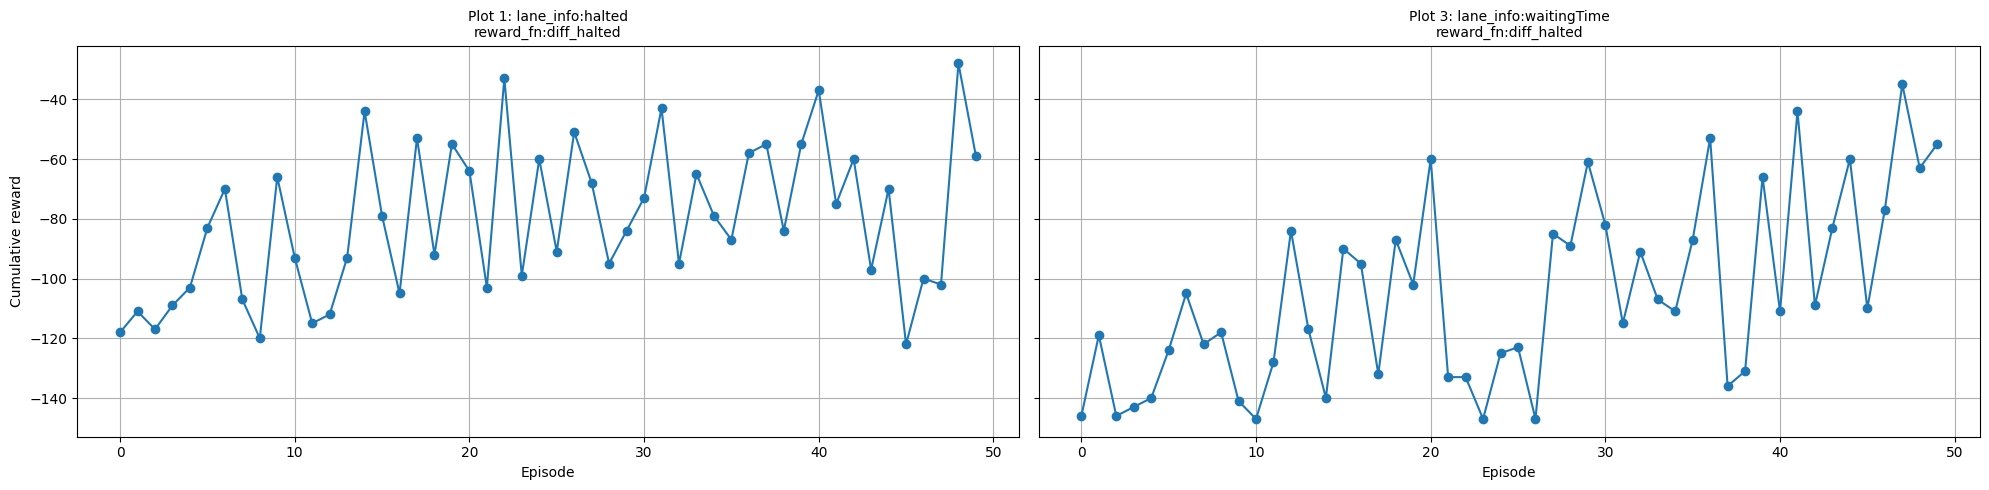

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
axes = axes.flatten()

dfs = []
j = 0
for i, result in enumerate(results_params_1):
    if i%2 == 0:
        metrics = result['metrics']
        df = pd.DataFrame(metrics)
        axes[j].plot(df['episode'], df['cumulative_reward'], marker='o')
        axes[j].set_xlabel('Episode')
        if j == 0:
            axes[j].set_ylabel('Cumulative reward')
        title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
        axes[j].set_title(title, fontsize=10)
        axes[j].grid(True)
        j = j + 1
plt.tight_layout()
plt.show()

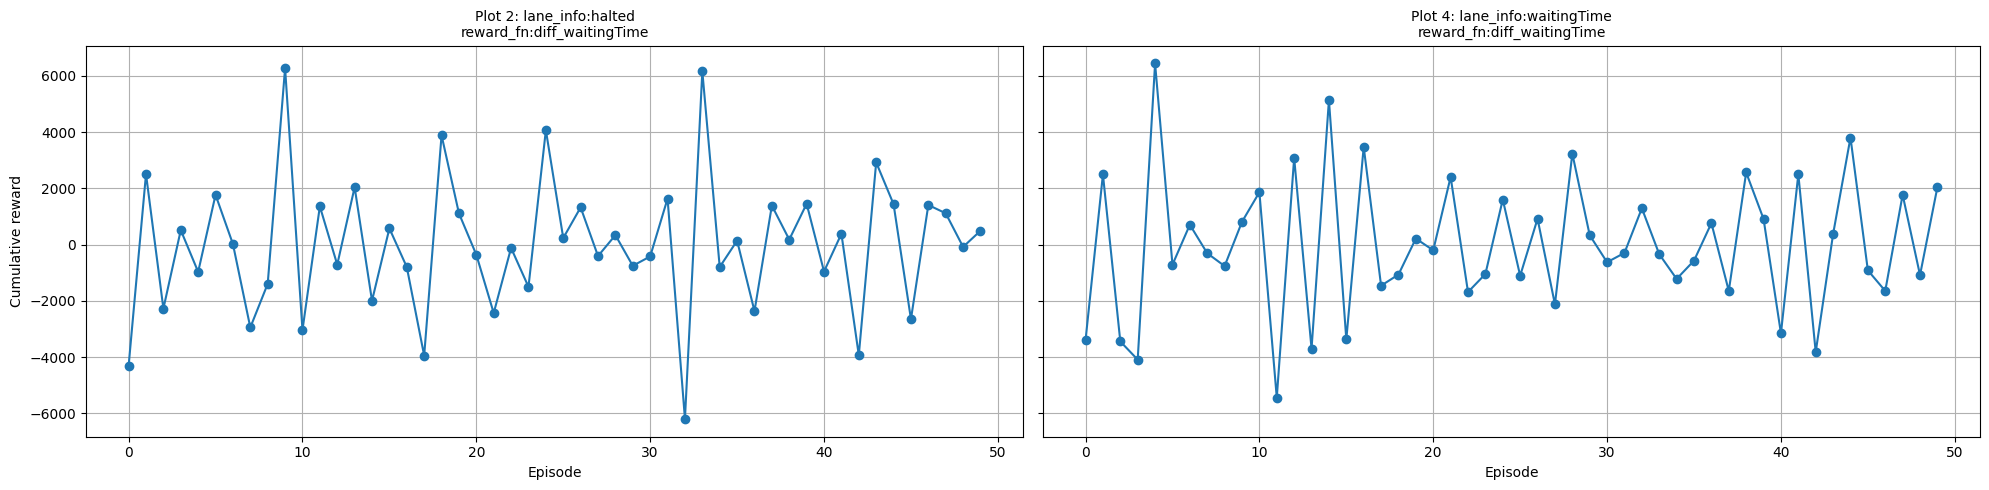

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
axes = axes.flatten()

dfs = []
j = 0
for i, result in enumerate(results_params_1):
    if i%2 != 0:
        metrics = result['metrics']
        df = pd.DataFrame(metrics)
        axes[j].plot(df['episode'], df['cumulative_reward'], marker='o')
        axes[j].set_xlabel('Episode')
        if j == 0:
            axes[j].set_ylabel('Cumulative reward')
        title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
        axes[j].set_title(title, fontsize=10)
        axes[j].grid(True)
        j = j + 1
plt.tight_layout()
plt.show()

In [36]:
param_grid["encode_intervals"]

[8, 10, 14]

In [40]:
results_params_2 = []
for encode_interval in param_grid["encode_intervals"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2.append({"params": params, "metrics": metrics })
    

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: encode_interval:8
 Retrying in 1 seconds
Learning with: encode_interval:10
 Retrying in 1 seconds
Learning with: encode_interval:14


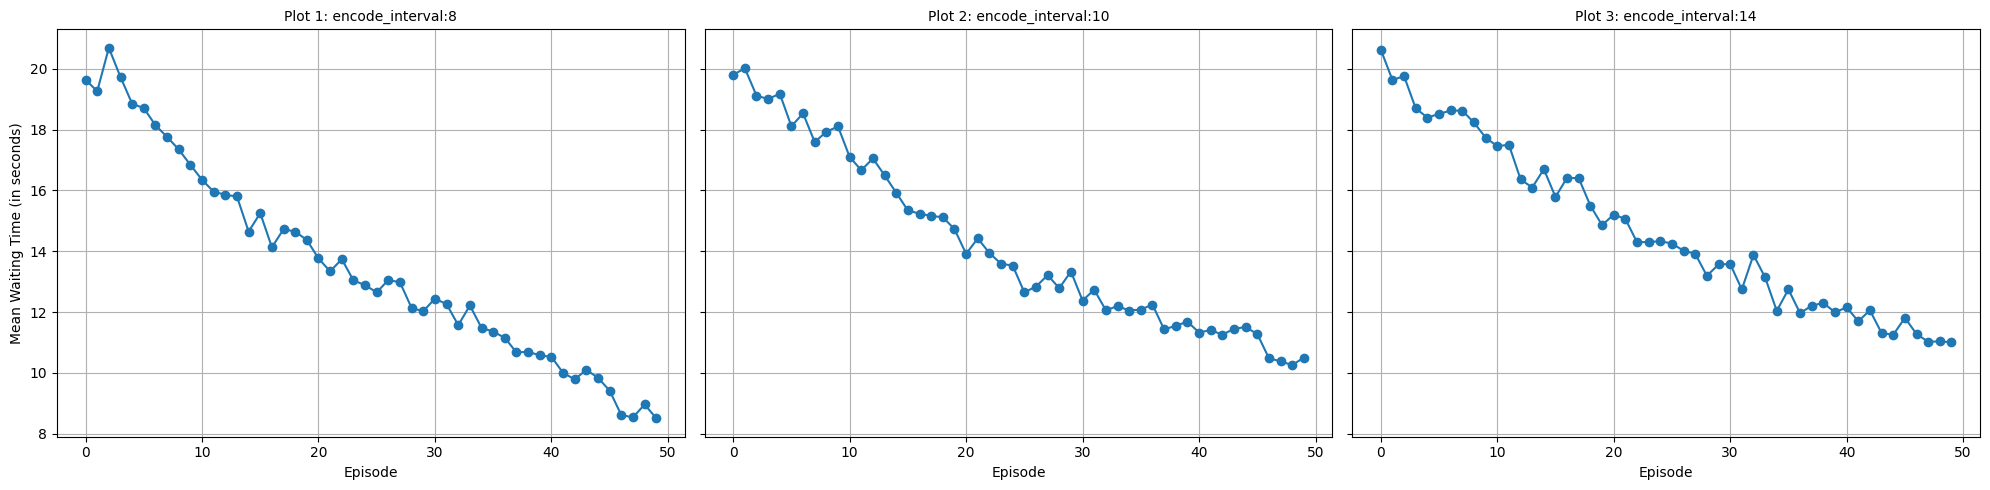

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

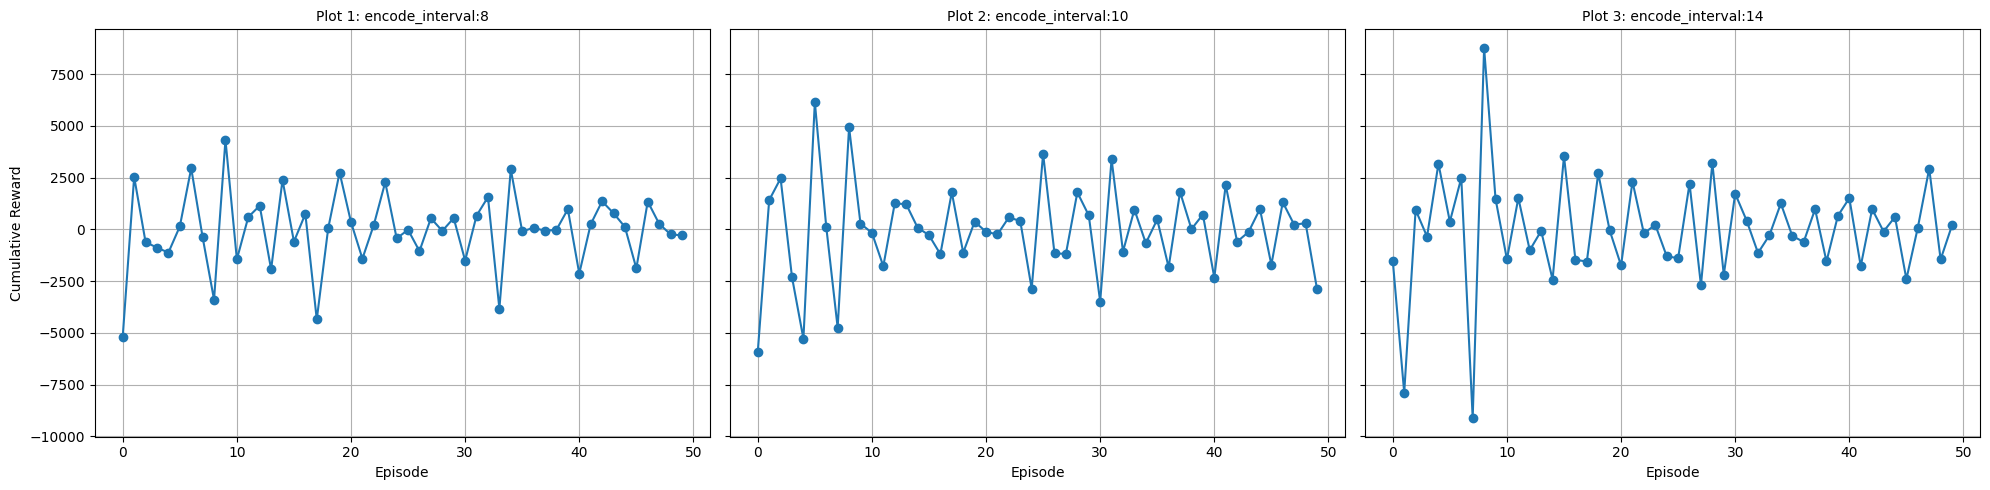

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['cumulative_reward'], marker='o')
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Cumulative Reward')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [48]:
for encode_interval in [4, 6]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: encode_interval:4
 Retrying in 1 seconds
Learning with: encode_interval:6


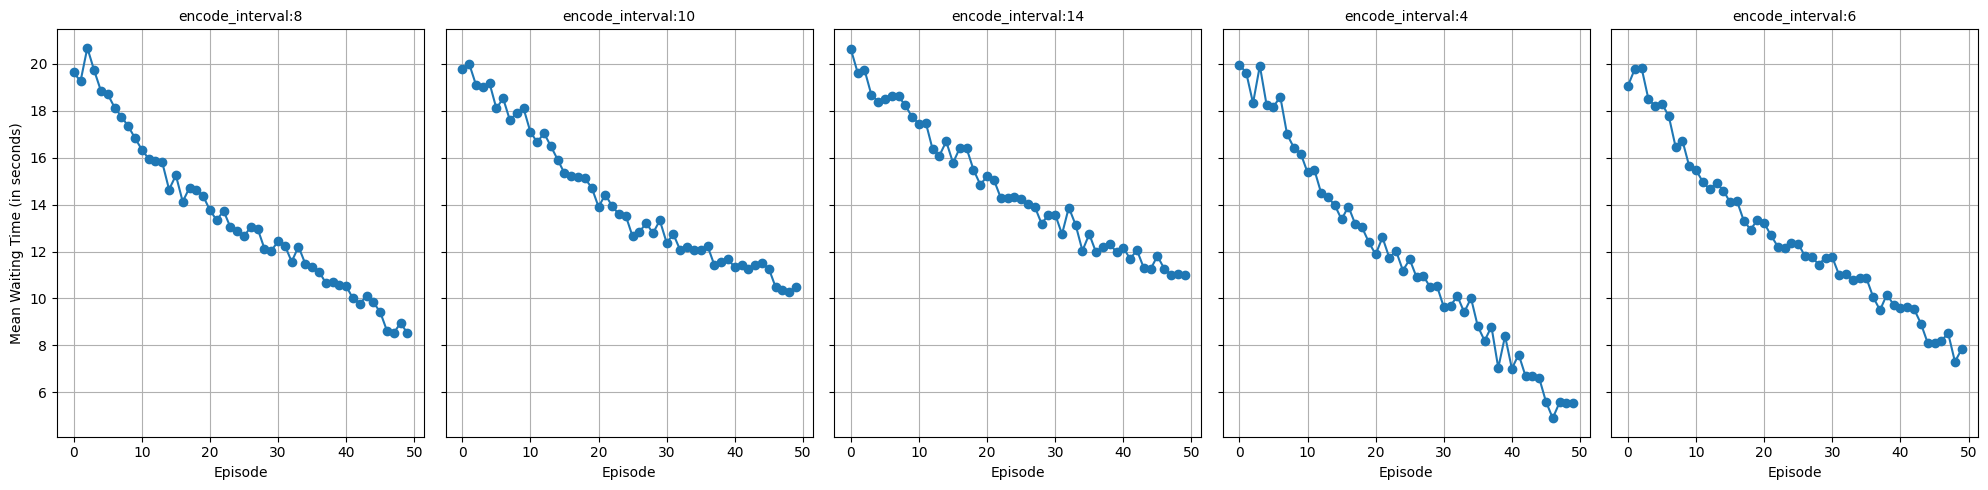

In [60]:
fig, axes = plt.subplots(1, 5, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

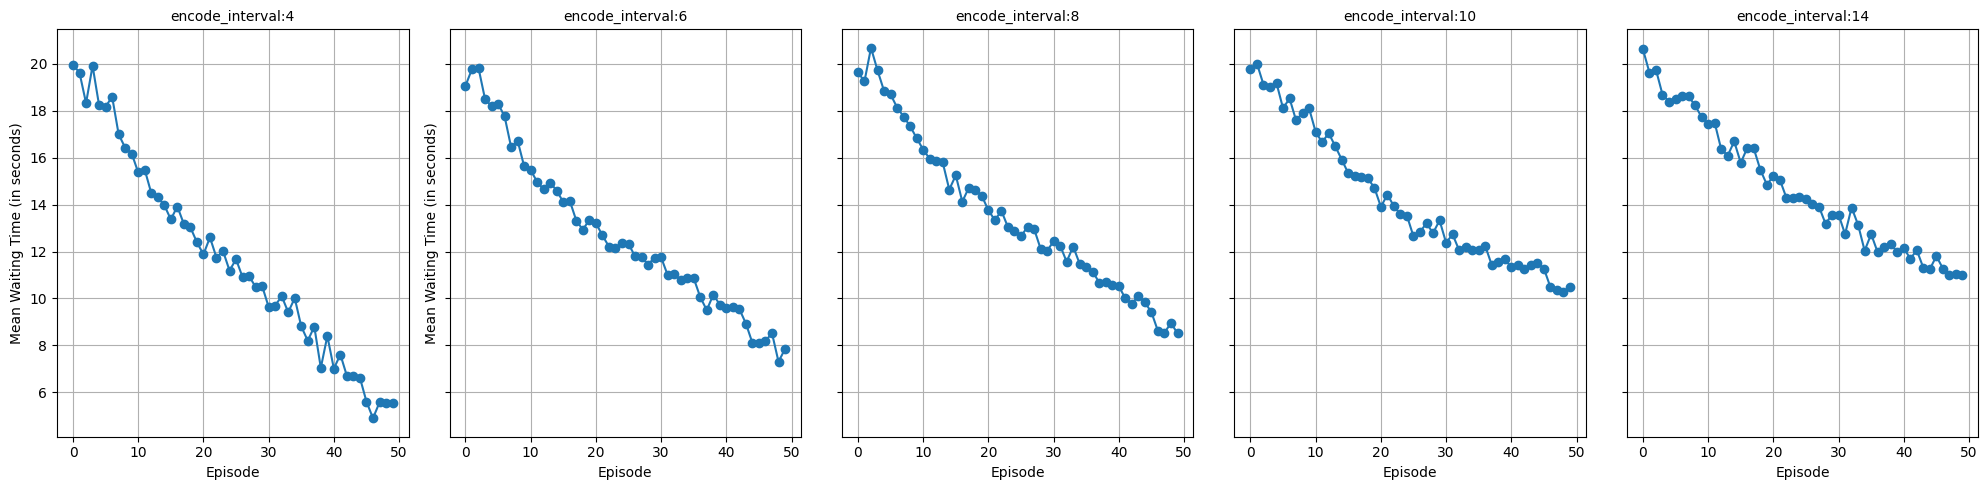

In [66]:
fig, axes = plt.subplots(1, 5, figsize=(20,5),sharey=True)
axes = axes.flatten()

result_4 = results_params_2[3]
metrics = result_4['metrics']
df = pd.DataFrame(metrics)
axes[0].plot(df['episode'], df['mean_waiting_time'], marker='o')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Mean Waiting Time (in seconds)')
title = split_long_string(f"{result_4['params']}", 40)
axes[0].set_title(title, fontsize=10)
axes[0].grid(True)

result_6 = results_params_2[4]
metrics = result_6['metrics']
df = pd.DataFrame(metrics)
axes[1].plot(df['episode'], df['mean_waiting_time'], marker='o')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Mean Waiting Time (in seconds)')
title = split_long_string(f"{result_6['params']}", 40)
axes[1].set_title(title, fontsize=10)
axes[1].grid(True)

result_8 = results_params_2[0]
metrics = result_8['metrics']
df = pd.DataFrame(metrics)
axes[2].plot(df['episode'], df['mean_waiting_time'], marker='o')
axes[2].set_xlabel('Episode')
title = split_long_string(f"{result_8['params']}", 40)
axes[2].set_title(title, fontsize=10)
axes[2].grid(True)

result_10 = results_params_2[1]
metrics = result_10['metrics']
df = pd.DataFrame(metrics)
axes[3].plot(df['episode'], df['mean_waiting_time'], marker='o')
axes[3].set_xlabel('Episode')
title = split_long_string(f"{result_10['params']}", 40)
axes[3].set_title(title, fontsize=10)
axes[3].grid(True)

result_14 = results_params_2[2]
metrics = result_14['metrics']
df = pd.DataFrame(metrics)
axes[4].plot(df['episode'], df['mean_waiting_time'], marker='o')
axes[4].set_xlabel('Episode')
title = split_long_string(f"{result_14['params']}", 40)
axes[4].set_title(title, fontsize=10)
axes[4].grid(True)

plt.tight_layout()
plt.show()

In [51]:
serializeParamResults(results_params_2, "results_params_2.csv")

In [58]:
if 'results_params_2' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_params_2 = deserializeParamResults("results_params_2.csv")

In [52]:
results_params_2_plus = []
for encode_interval in [4,14]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=125)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2_plus.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: encode_interval:4
 Retrying in 1 seconds
Learning with: encode_interval:14


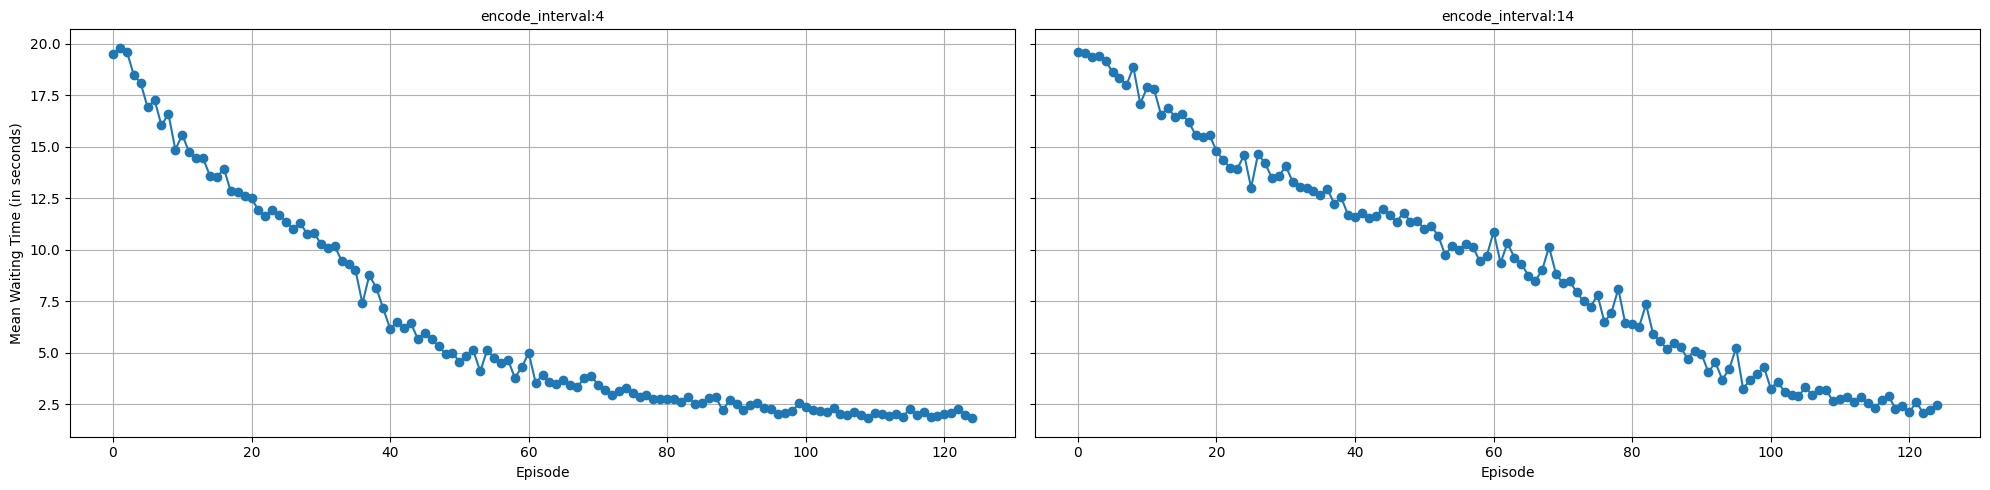

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(20,5),sharey=True)
axes = axes.flatten()

for i, result in enumerate(results_params_2_plus):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [58]:
serializeParamResults(results_params_2_plus, "results_params_2_plus.csv")

In [67]:
if 'results_params_2_plus' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_params_2_plus = deserializeParamResults("results_params_2_plus.csv")

In [61]:
results_encInt14 = []
env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=14, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=200)
params = "encode_interval:" + str(14)
print("Learning with: " + params)
metrics = agent.train();
results_encInt14.append({"params": params, "metrics": metrics })

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: encode_interval:14


/tmp/ipykernel_587494/1412441770.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


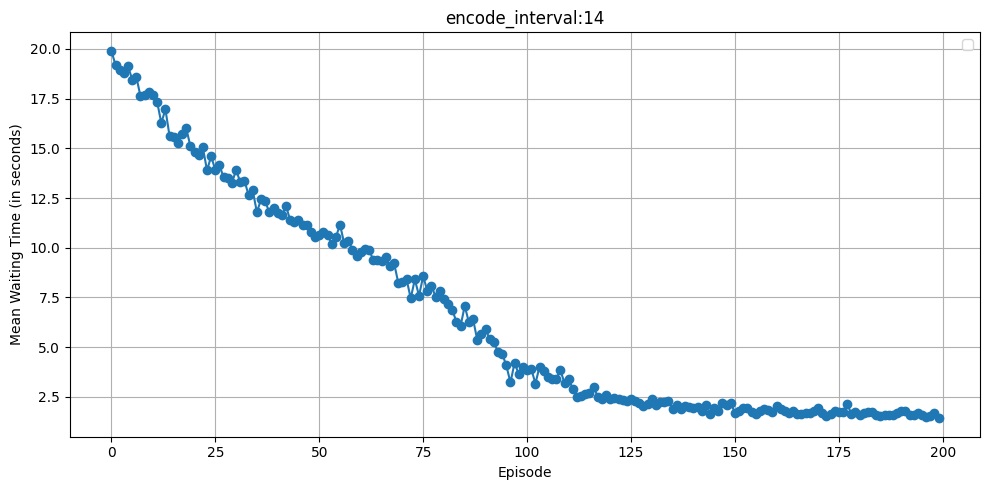

In [70]:
plt.figure(figsize=(10, 5))

metrics = results_encInt14[0]['metrics']
df = pd.DataFrame(metrics)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')

# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.legend()
plt.grid(True)
plt.title(split_long_string(f"{result['params']}", 40))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [68]:
serializeParamResults(results_encInt14, "results_encInt14.csv")

In [69]:
if 'results_encInt14' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_encInt14 = deserializeParamResults("results_encInt14.csv")

In [80]:
print("Tiempo de espera promedio en Episodio 125, con encode_interval=4", end=":\n\t")
print(results_params_2_plus[0]["metrics"][len(results_params_2_plus[0]["metrics"])-1]["mean_waiting_time"])
print("Tiempo de espera promedio en Episodio 200, con encode_interval=14", end=":\n\t")
print(results_encInt14[0]["metrics"][len(results_encInt14[0]["metrics"])-1]["mean_waiting_time"])

Tiempo de espera promedio en Episodio 50, con encode_interval=4:
	1.82034968487743
Tiempo de espera promedio en Episodio 200, con encode_interval=14:
	1.4175853049597538


Utilizar un valor alto de $encode\_interval$ (como 14) provoca que el agente aprenda una política de control de forma más lenta, resultando en una convergencia más tardía. Sin embargo, esto suele generar resultados ligeramente superiores en comparación a un $encode\_interval$ bajo (como 4).

Dado que la ejecución de un episodio en la simulación requiere un tiempo considerable, optamos por un valor intermedio de $encode\_interval$, específicamente 10.

In [37]:
encode_interval = 10

Sin embargo, para la exploración de los próximos parámetros utilizaremos $encode\_interval=4$

### Decay Rate & Starting Epsilon

In [94]:
results_epsilonGreedy_params = []

for start_epsilon in param_grid["start_epsilons"]:
    for decay_rate in param_grid["decay_rates"]:
        env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
        agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=decay_rate, episodes=100)
        params = "start_epsilon:" + str(start_epsilon)+",decay_rate:" + str(decay_rate)
        print("Learning with: " + params)
        metrics = agent.train()
        results_epsilonGreedy_params.append({"params": params, "metrics": metrics })
        
        

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: start_epsilon:1,decay_rate:0.02
 Retrying in 1 seconds
Learning with: start_epsilon:1,decay_rate:0.03
 Retrying in 1 seconds
Learning with: start_epsilon:0.8,decay_rate:0.02
 Retrying in 1 seconds
Learning with: start_epsilon:0.8,decay_rate:0.03


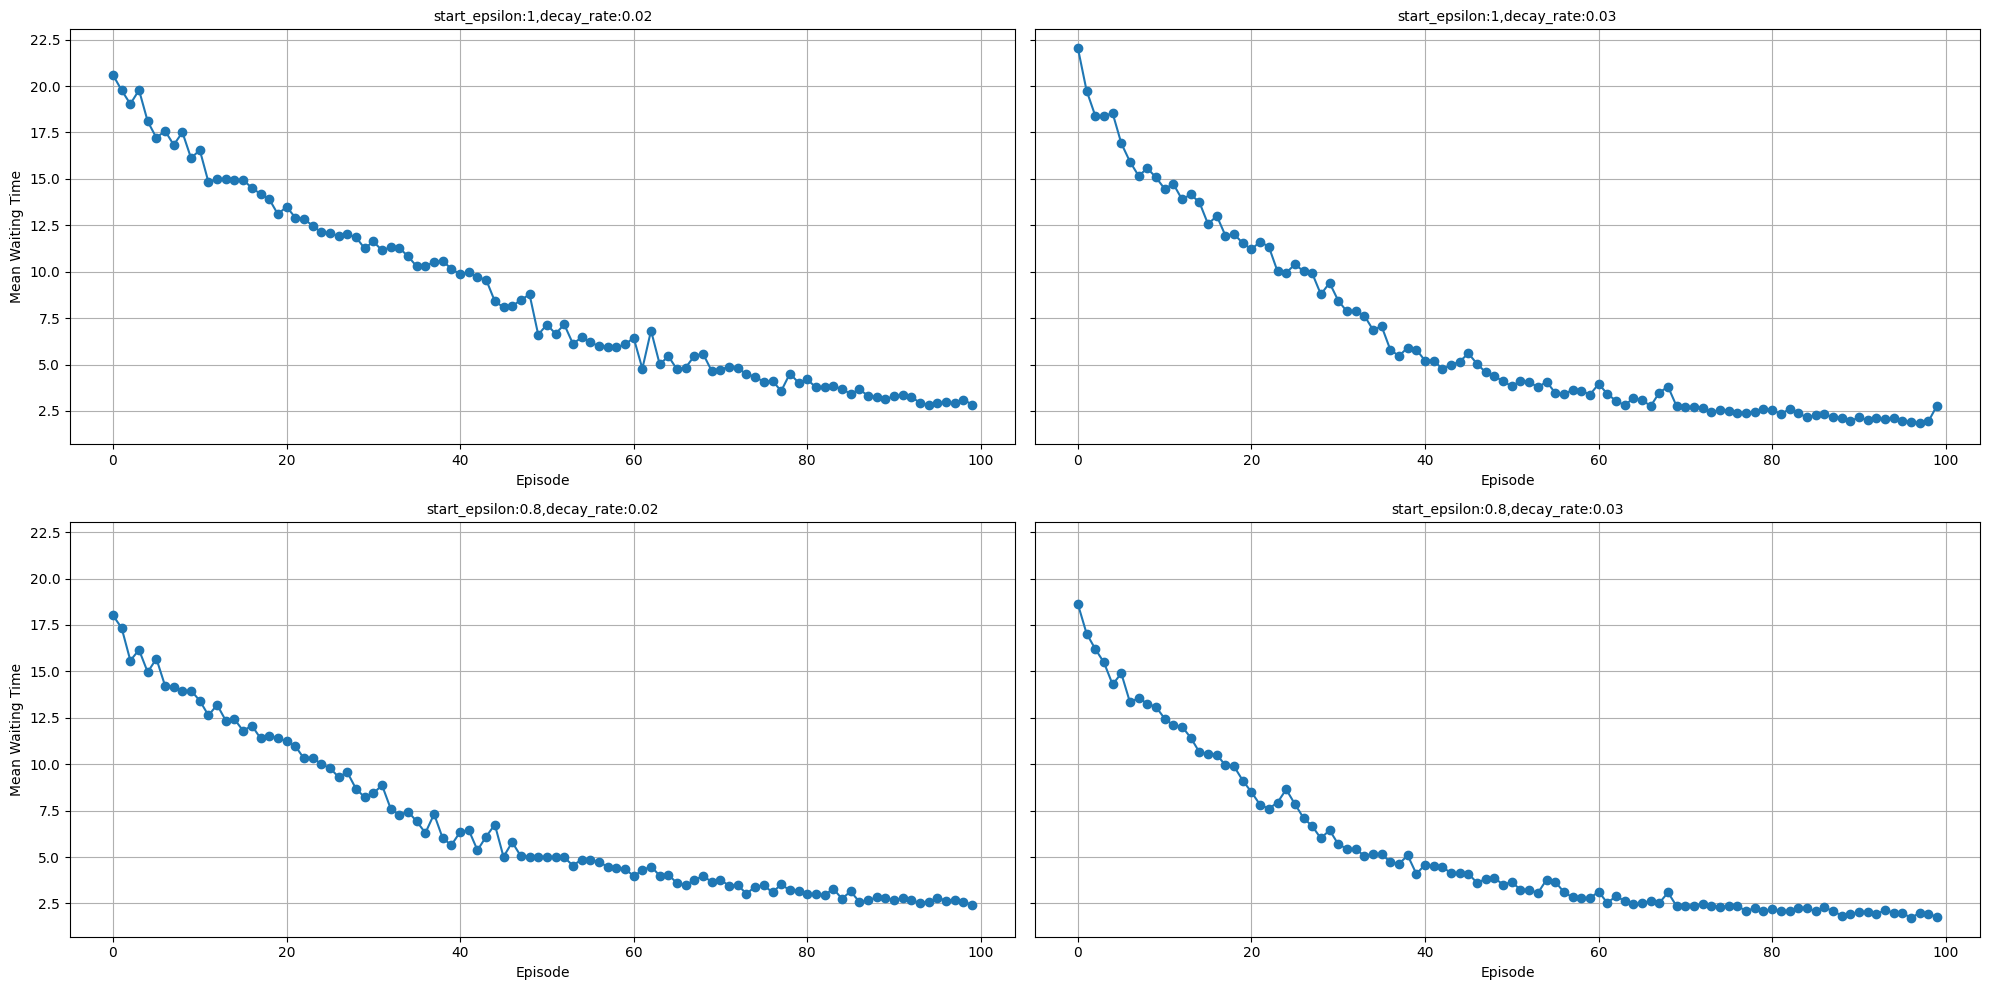

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20,10),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_epsilonGreedy_params):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i%2 == 0:
        axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [100]:
serializeParamResults(results_epsilonGreedy_params, "results_epsilonGreedy_params.csv")

In [55]:
if 'results_epsilonGreedy_params' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_epsilonGreedy_params = deserializeParamResults("results_epsilonGreedy_params.csv")

Como cabía esperar, un decay rate más alto, acorta la convergencia a una solución lo suficientemente buena. Adicionalmente la curva que determina la exploración del agente no sólo depende del decay rate, sino también de la cantidad de episodios de aprendizaje por refuerzo. Este parámetro se eligirá cuando se hayan explorado todos los demás parámetros y se realicen los entrenamientos finales para evaluar nuestro agente.

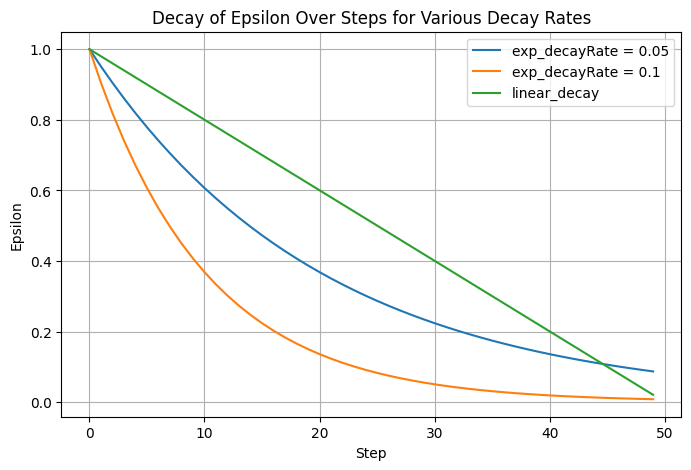

In [117]:
episodes = 50
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.05, 0.1]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

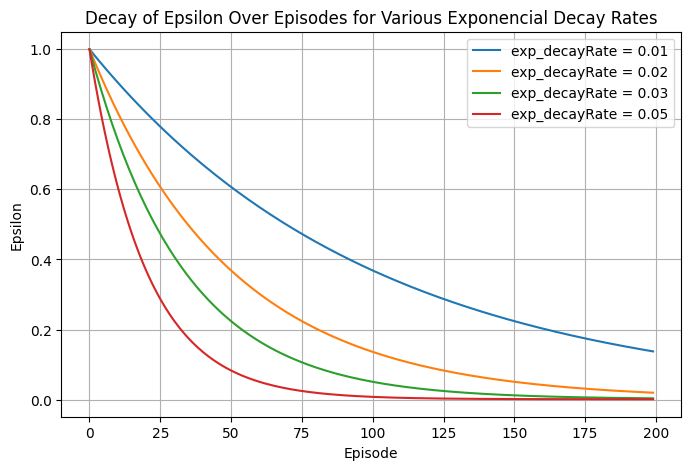

In [26]:
episodes = 200
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.01, 0.02, 0.03, 0.05]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
#plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Episodes for Various Exponencial Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

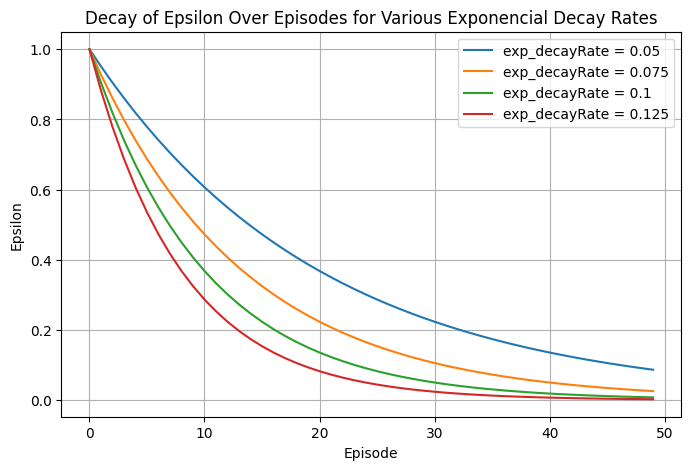

In [31]:
episodes = 50
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.05, 0.075, 0.1, 0.125]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
#plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Episodes for Various Exponencial Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

De forma arbitraria, durante lo queda de de la exploración de parémtros, se usaran varios decay rates dependiente de la cantidad de episodios.

In [40]:
decay_rate_100 = 0.02
decay_rate_50 = 0.05

En cuanto al epsilon inicial (start_epsilon), no hay observación clara con respecto a los dos valores usados (1 y 0.8). Solo la inherente al concepto de política epsilon-greedy. Un epsilon inicial de uno (1), hará que durante el primer episodio la exploración de acciones para cualquier estado sea completa. De forma arbitraria, escogemos $start\_epsilon=1$.

In [41]:
start_epsilon = 1

NameError: name 'decay_rate_100' is not defined

In [120]:
results_learning_rate = []

for learning_rate in param_grid["learning_rates"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=learning_rate, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=decay_rate_100, episodes=100)
    params = "learning_rate:" + str(learning_rate)
    print("Learning with: " + params)
    metrics = agent.train()
    results_learning_rate.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: learning_rate:0.1
 Retrying in 1 seconds
Learning with: learning_rate:0.01
 Retrying in 1 seconds
Learning with: learning_rate:0.001


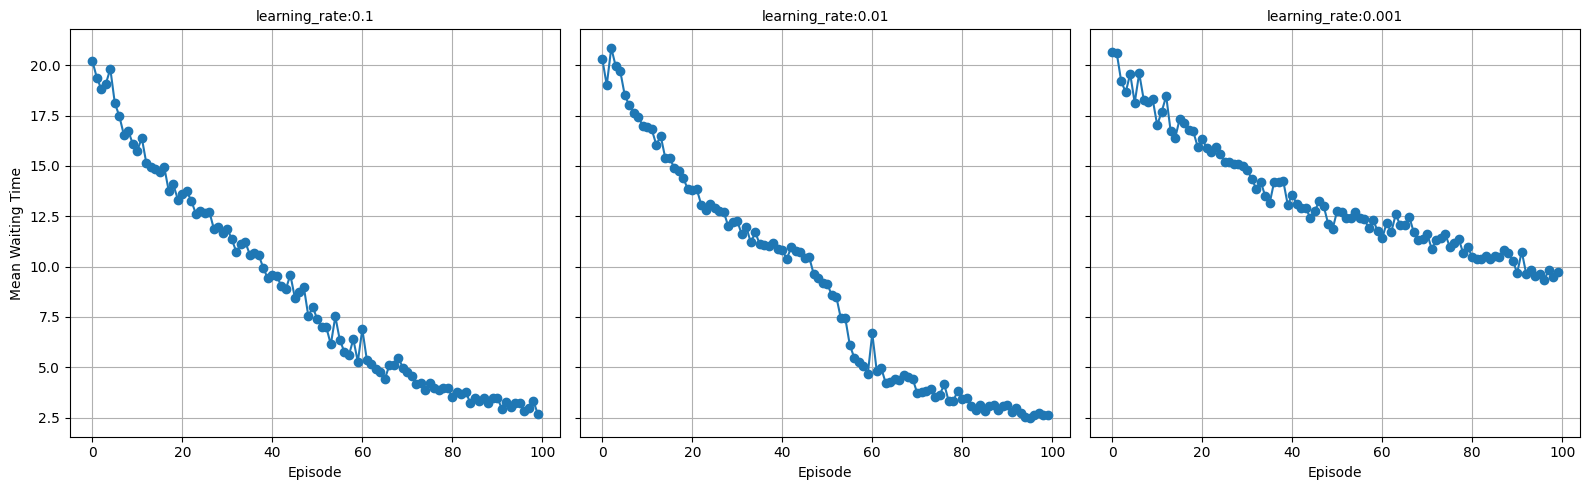

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(16,5),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_learning_rate):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i== 0:
        axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"{result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [121]:
serializeParamResults(results_learning_rate, "results_learning_rate.csv")

In [71]:
if 'results_learning_rate' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    results_learning_rate = deserializeParamResults("results_learning_rate.csv")

Al utilizar una tasa de aprendizaje 10 veces inferior a 0.01, el aprendizaje es muy lento. Por lo tanto utilizaremos un $learning\_rate = 0.01$

In [52]:
learning_rate = 0.01

In [ ]:
Semáforos estaticos

In [50]:
sumoCfgFile_unbalanced = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_unbalanced.sumocfg'))

In [ ]:


env = SumoEnvironment(sumocfgFile=sumoCfgFile_unbalanced, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=True, simTime=43800, sumoLog=False)

agent = ftl_agent.FixedTLAgent(env, 200)
ftl_agent_metrics = agent.run();


In [50]:
ftl_agent_metrics

[{'episode': 0,
  'cumulative_reward': -1659.0,
  'mean_waiting_time': 18.49865016721128},
 {'episode': 1,
  'cumulative_reward': -781.0,
  'mean_waiting_time': 18.411823354915335},
 {'episode': 2,
  'cumulative_reward': 278.0,
  'mean_waiting_time': 18.60441796970224},
 {'episode': 3,
  'cumulative_reward': -183.0,
  'mean_waiting_time': 18.537154856830206},
 {'episode': 4,
  'cumulative_reward': 232.0,
  'mean_waiting_time': 18.572630453081565},
 {'episode': 5,
  'cumulative_reward': -90.0,
  'mean_waiting_time': 18.642997129519774},
 {'episode': 6,
  'cumulative_reward': -377.0,
  'mean_waiting_time': 18.483078854124773},
 {'episode': 7,
  'cumulative_reward': 310.0,
  'mean_waiting_time': 18.60844873964878},
 {'episode': 8,
  'cumulative_reward': 33.0,
  'mean_waiting_time': 18.4524905516655},
 {'episode': 9,
  'cumulative_reward': 308.0,
  'mean_waiting_time': 18.500522985515442},
 {'episode': 10,
  'cumulative_reward': -624.0,
  'mean_waiting_time': 18.639593213818365},
 {'episod

/tmp/ipykernel_94382/236240199.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


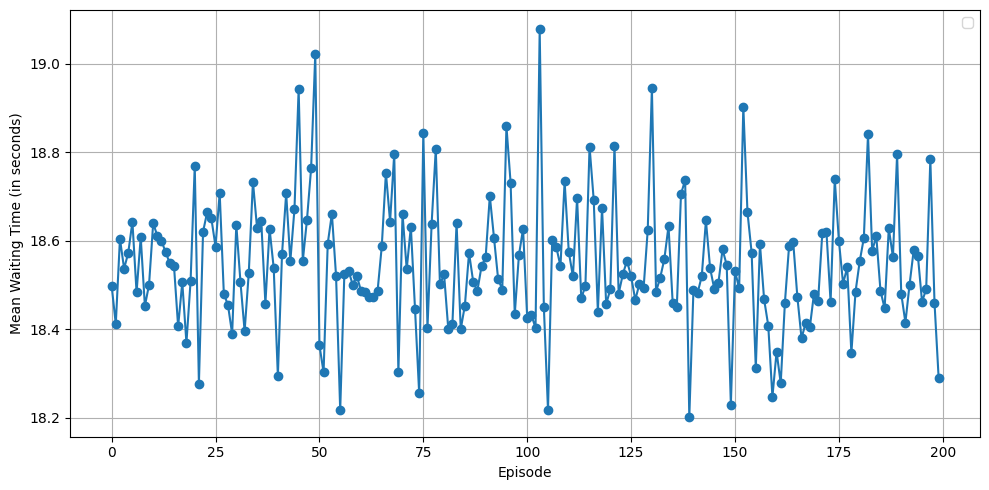

In [47]:
plt.figure(figsize=(10, 5))

df = pd.DataFrame(ftl_agent_metrics)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')

# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.legend()
plt.grid(True)


# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [52]:
serializeMetrics(ftl_agent_metrics, "ftl_agent_metrics.csv")

In [43]:
if 'ftl_agent_metrics' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    ftl_agent_metrics = deserializeMetrics("ftl_agent_metrics.csv")

In [38]:
env = SumoEnvironment(sumocfgFile=sumoCfgFile_unbalanced, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=learning_rate, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=0.025, episodes=200)
ql_agent_metrics = agent.train();

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK


In [53]:
serializeMetrics(ql_agent_metrics, "ql_agent_metrics_1.csv")

In [45]:
if 'ql_agent_metrics' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    ql_agent_metrics = deserializeMetrics("ql_agent_metrics_1.csv")

/tmp/ipykernel_94382/977330865.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


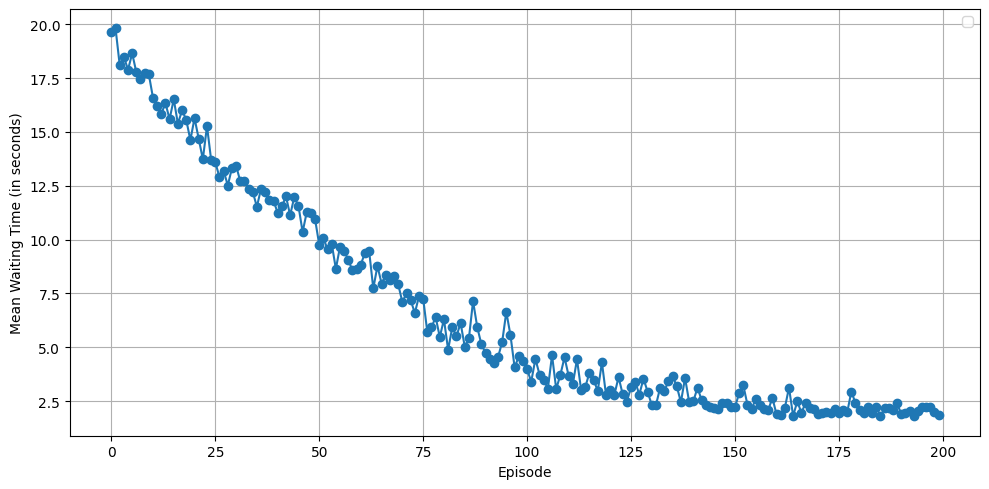

In [40]:
plt.figure(figsize=(10, 5))
df = pd.DataFrame(ql_agent_metrics)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')
# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_10525/660403550.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


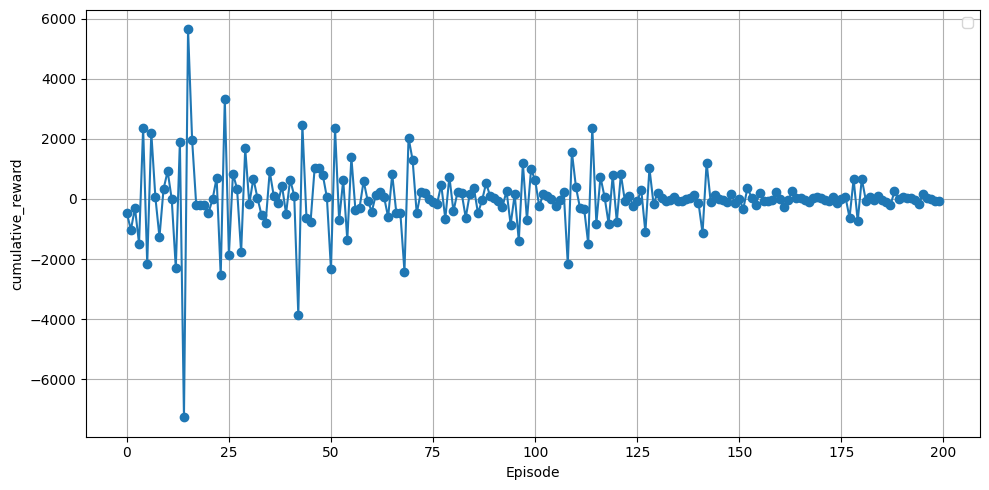

In [46]:
plt.figure(figsize=(10, 5))
df = pd.DataFrame(ql_agent_metrics)
plt.plot(df['episode'], df['cumulative_reward'], marker='o')
# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('cumulative_reward')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [48]:
param_grid["reward_fns"]

['diff_waitingTime', 'diff_cumulativeWaitingTime']

In [53]:
env = SumoEnvironment(sumocfgFile=sumoCfgFile_unbalanced, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn="diff_cumulativeWaitingTime", fixedTL=False, simTime=43800, sumoLog=False)
agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=learning_rate, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=0.025, episodes=200)
qla_cWT_metrics = agent.train();

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK


In [59]:
serializeMetrics(qla_cWT_metrics, "qla_cWT_metrics.csv")

/tmp/ipykernel_10525/618603604.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


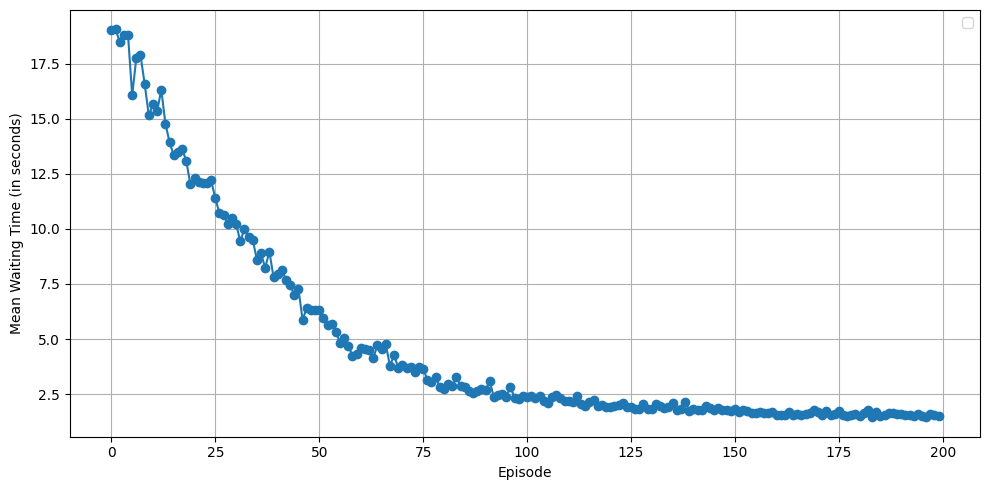

In [54]:
plt.figure(figsize=(10, 5))
df = pd.DataFrame(qla_cWT_metrics)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')
# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_10525/1682118961.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


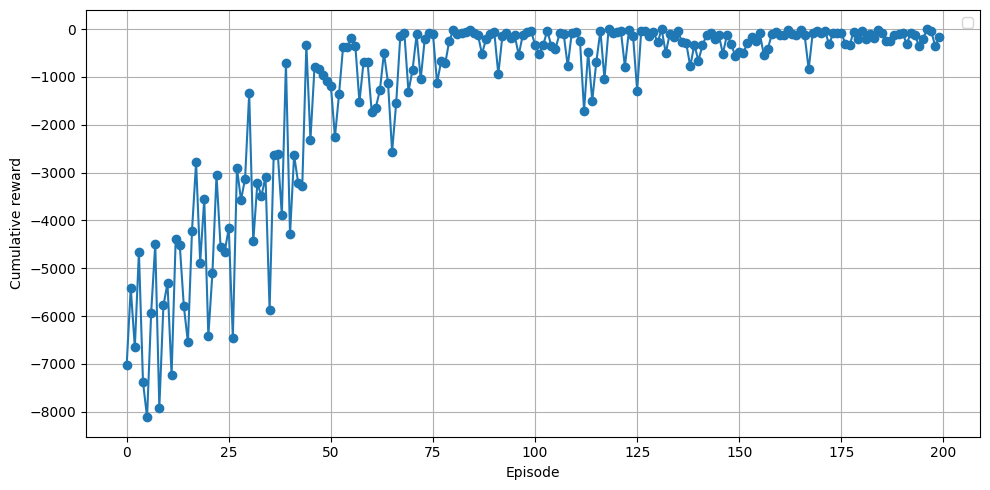

In [58]:
plt.figure(figsize=(10, 5))
df = pd.DataFrame(qla_cWT_metrics)
plt.plot(df['episode'], df['cumulative_reward'], marker='o')
# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Cumulative reward')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

/tmp/ipykernel_10525/3124360198.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


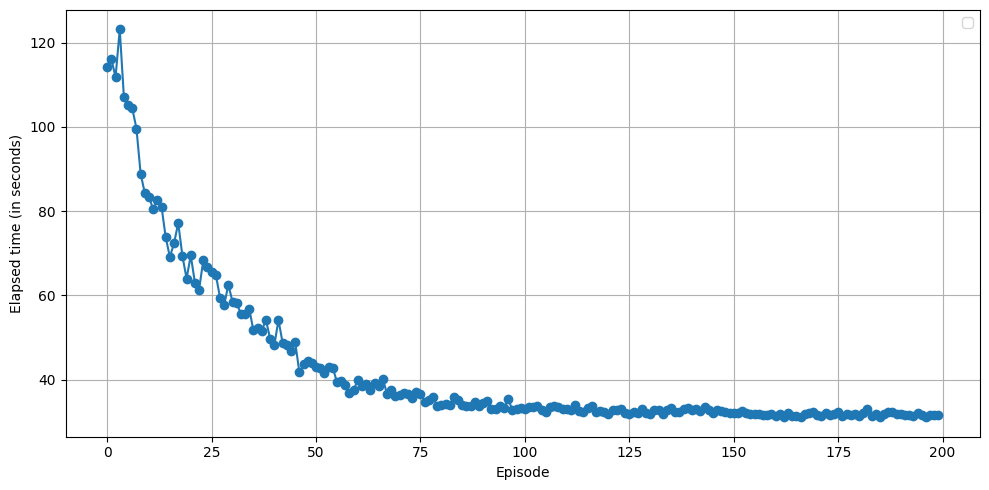

In [57]:
plt.figure(figsize=(10, 5))
df = pd.DataFrame(qla_cWT_metrics)
plt.plot(df['episode'], df['elapsed_time'], marker='o')
# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Elapsed time (in seconds)')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [65]:
results_WT=[]
for i in range(15):
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_unbalanced, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn="diff_waitingTime", fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=learning_rate, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=0.025, episodes=200)
    qla_WT_metrics = agent.train();
    results_WT.append({"run": i, "metrics": qla_WT_metrics})

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds
 Retrying in 1 seconds


In [69]:
serializeRunsResults(results_WT, "results_WT_15runs.csv")

In [74]:
df = deserializeMetrics("results_WT_15runs.csv")

In [76]:
mean_waiting_time_group = df.groupby('episode')['mean_waiting_time']
cumulative_reward_group = df.groupby('episode')['cumulative_reward']
elapsed_time_group = df.groupby('episode')['elapsed_time']

In [77]:
mean_mwt = mean_waiting_time_group.mean()
std_mwt = mean_waiting_time_group.std()

mean_cr = cumulative_reward_group.mean()
std_cr = cumulative_reward_group.std()

mean_ee = elapsed_time_group.mean()
std_ee = elapsed_time_group.std()

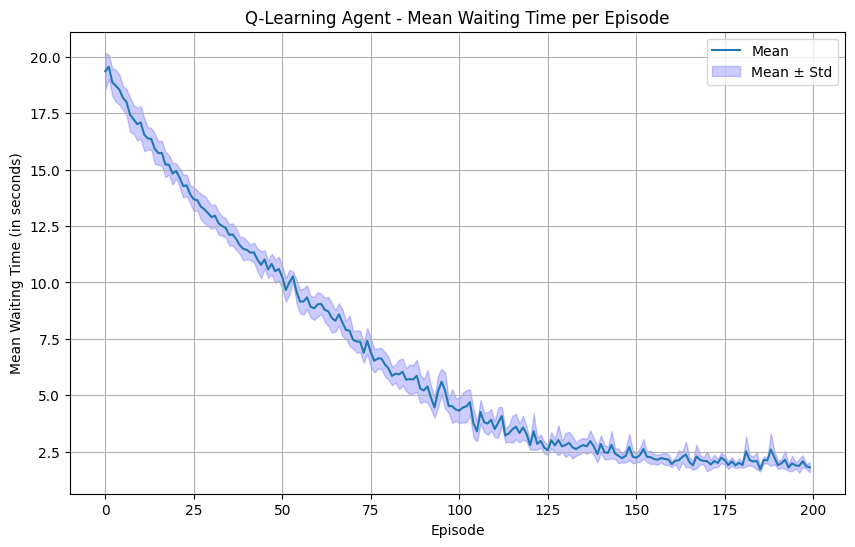

In [81]:
results_mwt = pd.DataFrame({
    'mean': mean_mwt,
    'std': std_mwt
})

results_mwt['upper'] = results_mwt['mean'] + results_mwt['std']
results_mwt['lower'] = results_mwt['mean'] - results_mwt['std']
plt.figure(figsize=(10, 6))
plt.plot(results_mwt.index, results_mwt['mean'], label='Mean')
plt.fill_between(results_mwt.index, results_mwt['lower'], results_mwt['upper'], color='b', alpha=0.2, label='Mean ± Std')

plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.title('Q-Learning Agent - Mean Waiting Time per Episode')
plt.legend()
plt.grid(True)
plt.show()


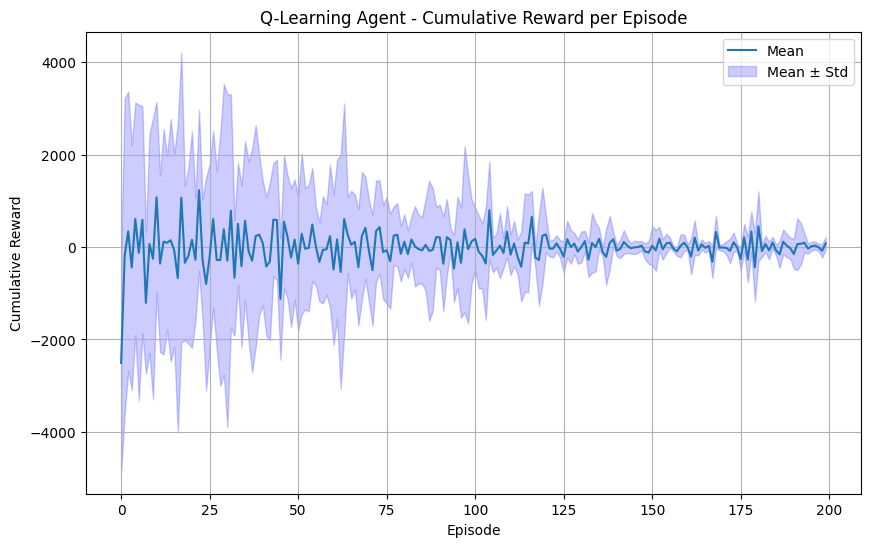

In [80]:
results_cr = pd.DataFrame({
    'mean': mean_cr,
    'std': std_cr
})

results_cr['upper'] = results_cr['mean'] + results_cr['std']
results_cr['lower'] = results_cr['mean'] - results_cr['std']
plt.figure(figsize=(10, 6))
plt.plot(results_cr.index, results_cr['mean'], label='Mean')
plt.fill_between(results_cr.index, results_cr['lower'], results_cr['upper'], color='b', alpha=0.2, label='Mean ± Std')

plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning Agent - Cumulative Reward per Episode')
plt.legend()
plt.grid(True)
plt.show()


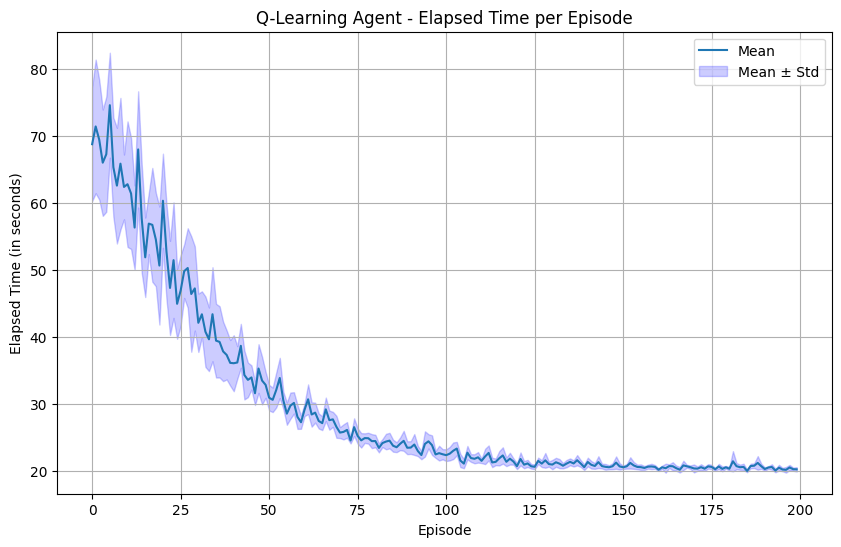

In [82]:
results_ee = pd.DataFrame({
    'mean': mean_ee,
    'std': std_ee
})

results_ee['upper'] = results_ee['mean'] + results_ee['std']
results_ee['lower'] = results_ee['mean'] - results_ee['std']
plt.figure(figsize=(10, 6))
plt.plot(results_ee.index, results_ee['mean'], label='Mean')
plt.fill_between(results_ee.index, results_ee['lower'], results_ee['upper'], color='b', alpha=0.2, label='Mean ± Std')

plt.xlabel('Episode')
plt.ylabel('Elapsed Time (in seconds)')
plt.title('Q-Learning Agent - Elapsed Time per Episode')
plt.legend()
plt.grid(True)
plt.show()


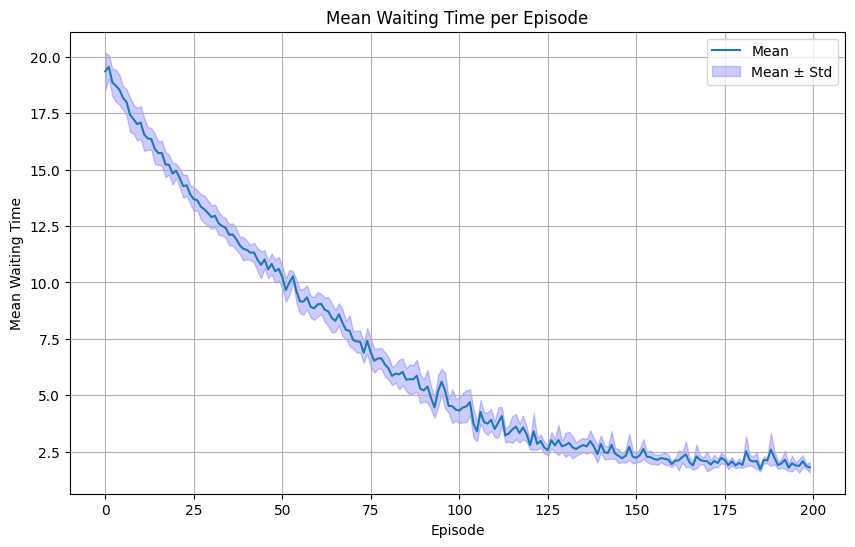

In [ ]:
if 'ql_agent_metrics' in locals():
    print("La variable ya existe en el ámbito local.")
else:
    ql_agent_metrics = deserializeMetrics("ql_agent_metrics_1.csv")